In [21]:
import skrebate
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import balanced_accuracy_score

In [1]:
from data_preparation import get_artificial_data
train_art, train_labels, test_art = get_artificial_data()
train_labels = (train_labels == 1) + 0

# Baseline model

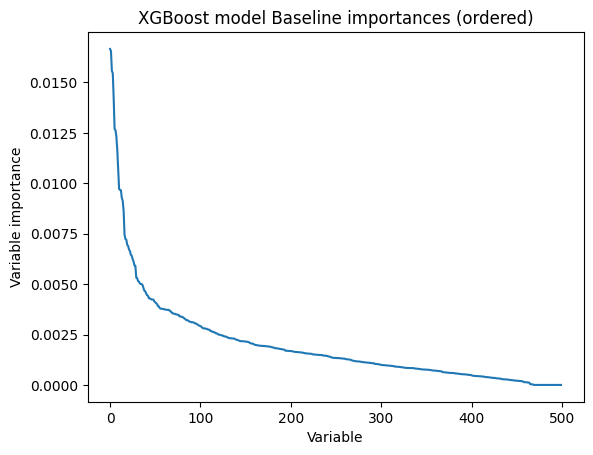

In [57]:
baseline = XGBClassifier()
baseline.fit(train_art, train_labels)
plt.plot(np.sort(baseline.feature_importances_)[::-1])
plt.title("XGBoost model Baseline importances (ordered)")
plt.ylabel("Variable importance")
plt.xlabel("Variable")
plt.show()

In [59]:
baseline_acc = cross_val_score(baseline, train_art, train_labels, scoring="balanced_accuracy")
print(baseline_acc)
print(np.mean(baseline_acc))

[0.7675 0.815  0.785  0.7975 0.7925]
0.7914999999999999


# Boruta

In [112]:
def relu(x):
    return np.maximum(0., x)

def artificial_scoring(ba, m):
    return ba - .01 * relu(m/5 - 1)

In [6]:
boruta_fs = BorutaPy(
    RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5),
    n_estimators='auto', verbose=1, random_state=1)
boruta_fs.fit(train_art.values, train_labels.values.ravel())

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=129, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F325E6EA640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F325E6EA640, verbose=1)

In [15]:
boruta_simple_cv_score = cross_val_score(
    XGBClassifier(), 
    boruta_fs.transform(train_art.values), 
    np.array(train_labels).flatten(), 
    scoring="balanced_accuracy"
)
print(boruta_simple_cv_score)

[0.8725 0.88   0.8575 0.85   0.8575]


In [13]:
boruta_fs.n_features_

20

In [17]:
artificial_scoring(np.mean(boruta_simple_cv_score), boruta_fs.n_features_) # expected score

0.8334999999999999

# Trimming search space
Primarily to save time, it seems only 20 features are even worth looking at.

In [66]:
np.sum(boruta_fs.ranking_ < 32)

50

In [76]:
trim_art = train_art.loc[:, boruta_fs.ranking_ < 32]
trim_art

,4,10,13,28,38,48,55,64,105,128,...,431,433,442,451,453,455,472,475,481,493
0,452,455,507,459,473,440,469,648,181,452,...,528,533,568,463,471,630,515,401,463,485
1,587,434,503,475,480,499,485,488,431,473,...,500,442,463,474,311,582,465,549,448,338
2,448,468,491,491,480,460,525,485,593,487,...,517,569,503,481,606,424,485,454,470,650
3,495,455,472,472,486,529,478,415,698,493,...,494,565,447,472,545,456,457,602,473,572
4,466,432,434,472,475,429,493,387,451,475,...,517,462,536,472,426,465,500,560,456,435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,463,513,525,462,479,505,495,482,541,481,...,475,603,509,467,570,489,483,538,462,588
1996,495,494,517,496,481,448,507,311,696,497,...,445,475,421,488,423,403,444,601,465,424
1997,485,534,512,500,470,544,485,540,752,498,...,486,571,428,489,643,438,449,437,480,687
1998,542,525,448,471,481,490,467,543,524,481,...,496,608,563,472,691,444,511,387,517,750


# RFE

In [77]:
def art_scorer(est, X, y):
    yhat = est.predict(X)
    return artificial_scoring(
        balanced_accuracy_score(y, yhat),
        np.sum(est.feature_importances_ != 0.)
    )

In [45]:
rfe_fs = RFECV(
    XGBClassifier(),
    step=1,
    min_features_to_select=5,
    scoring=art_scorer
)

In [78]:
rfe_fs.fit(trim_art.values, train_labels.values.ravel())

RFECV(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      min_features_to_select=5,
      scoring=<function art_scorer at 0x7f3236146560>)

In [79]:
rfe_fs.cv_results_

{'mean_test_score': array([0.819 , 0.8455, 0.8495, 0.846 , 0.8475, 0.8505, 0.857 , 0.857 ,
        0.8475, 0.85  , 0.845 , 0.847 , 0.8435, 0.8435, 0.843 , 0.831 ,
        0.825 , 0.8245, 0.824 , 0.8075, 0.8115, 0.803 , 0.816 , 0.8075,
        0.8025, 0.799 , 0.7975, 0.796 , 0.7925, 0.7895, 0.7895, 0.786 ,
        0.7675, 0.7755, 0.77  , 0.7645, 0.767 , 0.765 , 0.772 , 0.7555,
        0.761 , 0.7585, 0.758 , 0.7505, 0.752 , 0.744 ]),
 'std_test_score': array([0.03363778, 0.01890767, 0.01707337, 0.01317194, 0.01536229,
        0.01298075, 0.00751665, 0.01113553, 0.01067708, 0.00533854,
        0.00547723, 0.00888819, 0.01048809, 0.00509902, 0.00888819,
        0.01124722, 0.01615549, 0.01513275, 0.01118034, 0.01958316,
        0.02136586, 0.0199374 , 0.01557241, 0.01496663, 0.02129554,
        0.01428286, 0.01544345, 0.0209165 , 0.01868154, 0.01710263,
        0.0150333 , 0.009     , 0.02222611, 0.01632483, 0.02187464,
        0.0116619 , 0.02130728, 0.02390607, 0.01866815, 0.01488288,
 

In [85]:
max(rfe_fs.cv_results_["mean_test_score"]) # expected score

0.857

In [117]:
np.argmax(rfe_fs.cv_results_["mean_test_score"]) + 5 # n_features

11

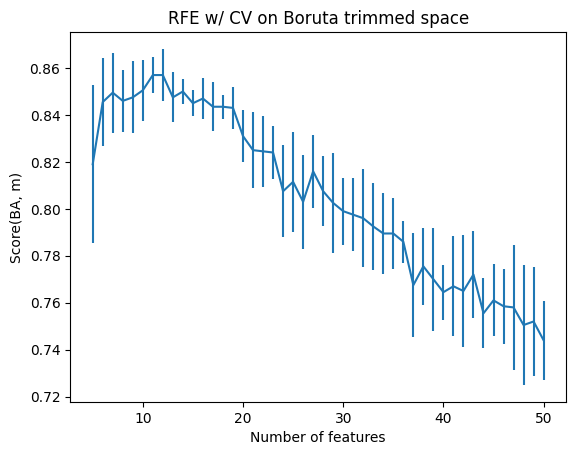

In [115]:
plt.errorbar(np.arange(0, len(rfe_fs.cv_results_["mean_test_score"])) + 5, rfe_fs.cv_results_["mean_test_score"], yerr=rfe_fs.cv_results_["std_test_score"])
plt.title("RFE w/ CV on Boruta trimmed space")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

# ReliefF
2 and 4 nearest neighbors

In [86]:
relief2n_fs = skrebate.ReliefF(n_features_to_select=20, n_neighbors=2, n_jobs=-1)
relief4n_fs = skrebate.ReliefF(n_features_to_select=20, n_neighbors=4, n_jobs=-1)

In [91]:
relief2n_fs.fit(trim_art.values.astype("float"), train_labels.values.ravel())
relief4n_fs.fit(trim_art.values.astype("float"), train_labels.values.ravel())

ReliefF(n_features_to_select=20, n_jobs=-1, n_neighbors=4)

In [122]:
relief2n_slide_results = []
relief2n_slide_indexes = []

for i in range(5, 50):
    relief2n_fs.set_params(n_features_to_select=i)
    relief_data = relief2n_fs.transform(trim_art.values.astype("float"))
    clf = XGBClassifier()
    BA_cv = cross_val_score(clf, relief_data, train_labels.values.ravel(), scoring="balanced_accuracy")
    relief2n_slide_results.append(BA_cv)
    relief2n_slide_indexes.append(i)

    
relief2n_df = pd.DataFrame(relief2n_slide_results)
relief2n_df = pd.concat((
    relief2n_df,
    relief2n_df.agg(["mean", "std"], axis=1),
    pd.DataFrame({"n_features": relief2n_slide_indexes})
), axis=1)

In [134]:
relief2n_df["mean_score"] = artificial_scoring(relief2n_df["mean"], relief2n_df["n_features"])
print(max(relief2n_df["mean_score"])) # expected score
print(relief2n_df[relief2n_df["mean_score"] == max(relief2n_df["mean_score"])]["n_features"].values[0]) # n_features

0.848
14


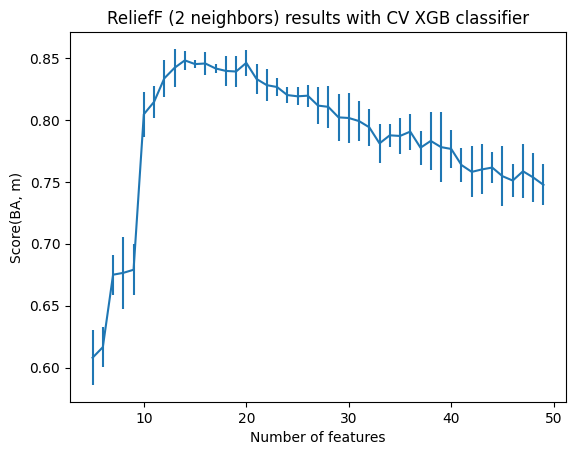

In [148]:
plt.errorbar(relief2n_df["n_features"], relief2n_df["mean_score"], yerr=relief2n_df["std"])
plt.title("ReliefF (2 neighbors) results with CV XGB classifier")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

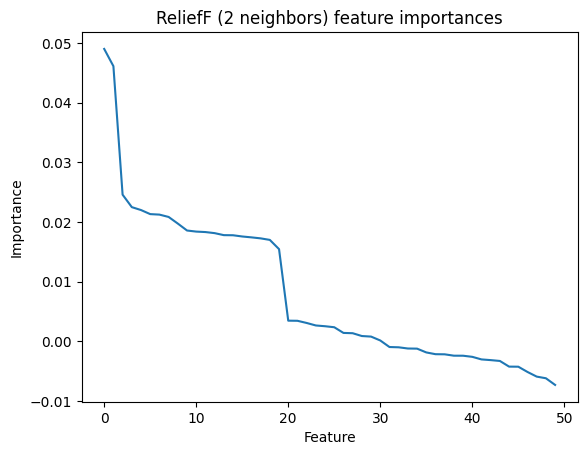

In [153]:
plt.plot(np.sort(relief2n_fs.feature_importances_)[::-1])
plt.title("ReliefF (2 neighbors) feature importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [ ]:
relief4n_slide_results = []
relief4n_slide_indexes = []

for i in range(5, 50):
    relief4n_fs.set_params(n_features_to_select=i)
    relief_data = relief4n_fs.transform(trim_art.values.astype("float"))
    clf = XGBClassifier()
    BA_cv = cross_val_score(clf, relief_data, train_labels.values.ravel(), scoring="balanced_accuracy")
    relief4n_slide_results.append(BA_cv)
    relief4n_slide_indexes.append(i)

    
relief4n_df = pd.DataFrame(relief4n_slide_results)
relief4n_df = pd.concat((
    relief4n_df,
    relief4n_df.agg(["mean", "std"], axis=1),
    pd.DataFrame({"n_features": relief4n_slide_indexes})
), axis=1)


In [137]:
relief4n_df["mean_score"] = artificial_scoring(relief4n_df["mean"], relief4n_df["n_features"])
print(max(relief4n_df["mean_score"])) # expected score
print(relief4n_df[relief4n_df["mean_score"] == max(relief4n_df["mean_score"])]["n_features"].values[0]) # n_features

0.8480000000000001
13


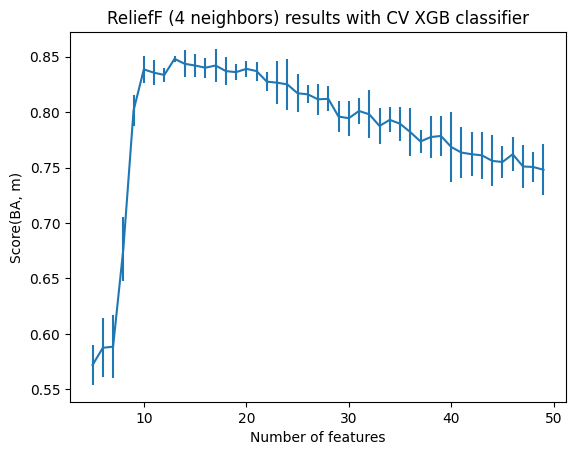

In [147]:
plt.errorbar(relief4n_df["n_features"], relief4n_df["mean_score"], yerr=relief4n_df["std"])
plt.title("ReliefF (4 neighbors) results with CV XGB classifier")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

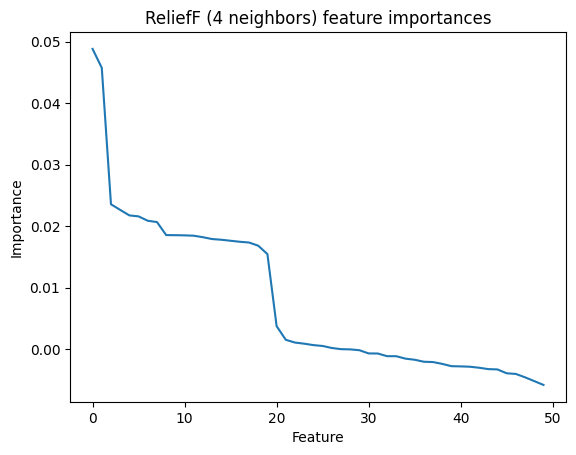

In [157]:
plt.plot(np.sort(relief4n_fs.feature_importances_)[::-1])
plt.title("ReliefF (4 neighbors) feature importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

# TuRF

In [139]:
turf_fs = skrebate.TuRF(
    core_algorithm="ReliefF", n_features_to_select=20, pct=0.25, n_jobs=-1
).fit(
    np.array(trim_art).astype("float"), 
    np.array(train_labels).flatten(),
    headers=list(trim_art)
)

In [143]:
turf_slide_results = []
turf_slide_indexes = []

for i in range(5, 50):
    turf_fs.set_params(n_features_to_select=i)
    relief_data = turf_fs.transform(trim_art.values.astype("float"))
    clf = XGBClassifier()
    BA_cv = cross_val_score(clf, relief_data, train_labels.values.ravel(), scoring="balanced_accuracy")
    turf_slide_results.append(BA_cv)
    turf_slide_indexes.append(i)

    
turf_df = pd.DataFrame(turf_slide_results)
turf_df = pd.concat((
    turf_df,
    turf_df.agg(["mean", "std"], axis=1),
    pd.DataFrame({"n_features": turf_slide_indexes})
), axis=1)


In [144]:
turf_df["mean_score"] = artificial_scoring(turf_df["mean"], turf_df["n_features"])
print(max(turf_df["mean_score"])) # expected score
print(turf_df[turf_df["mean_score"] == max(turf_df["mean_score"])]["n_features"].values[0]) # n_features

0.847
15


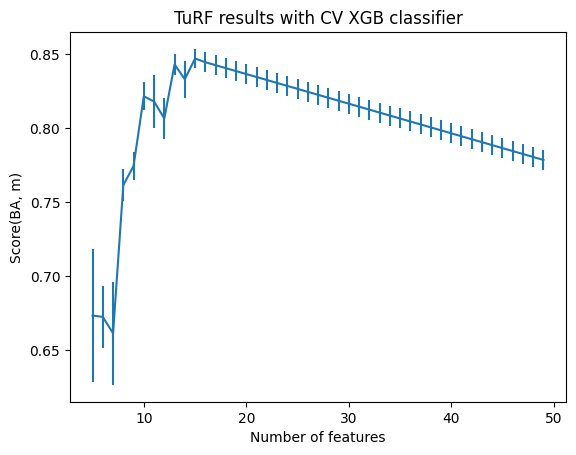

In [146]:
plt.errorbar(turf_df["n_features"], turf_df["mean_score"], yerr=turf_df["std"])
plt.title("TuRF results with CV XGB classifier")
plt.ylabel("Score(BA, m)")
plt.xlabel("Number of features")
plt.show()

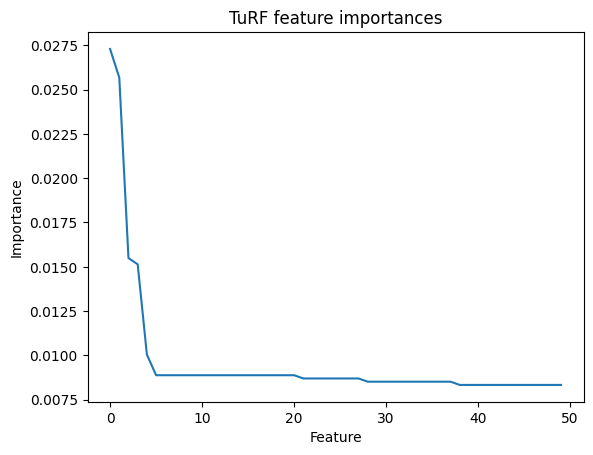

In [158]:
plt.plot(np.sort(turf_fs.feature_importances_)[::-1])
plt.title("TuRF feature importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()